In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style = 'white', context = 'notebook', palette = 'deep')

print('Main Modules imported successfully :)')

Main Modules imported successfully :)


<H3> Load Data

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train.shape

(891, 12)

In [7]:
IDtest = test['PassengerId']

In [8]:
IDtest

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


I notice that <b> Age </b> has fewer entries, which means that it has (891-714) null entries. 
Name, Sex, Ticket, Cabin, and Embarked columns has object datatypes.

We will use the median age to fill the empty age entries.

In [11]:
#Let's take a look at the numerical attributes of the dataset:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We can see that only 38% of the passengers survived.

In [12]:
#Let's Check that 'Survived' Column contains only values of zeros and ones:

train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Now let's take a look at the categorical attributes:

In [13]:
train['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [14]:
train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [15]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Now let's build our preprocessing pipelines. We will reuse the DataframeSelector to select specific attributes from the dataframe:

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names]

<b> Note: </b> 

By using BaseEstimator, and TransformerMixin as base classes (Sci-kit learn doesnot rely on inheritance, but rather duck typing). We get more methods for free. So we need to only implement fit (returns self), and transform methods. Check page 98 in the book.

Let's build the pipeline for numerical attributes:

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer #This is used to fill missing values and decide filling strategy

In [18]:
num_pipeline = Pipeline([
                        ('select_numeric', DataFrameSelector(['Age', 'SibSp', 'Parch', 'Fare'])),
                        ('imputer', SimpleImputer(strategy = 'median')),
])

In [21]:
num_pipeline.fit_transform(train)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

We will also need an imputer for the string categorical columns (the egular SimpleImputer does not work on those):

In [34]:
#Inspired from stackoverflow https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn:

class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y= None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X], index = X.columns)
        return self
    def transform(self, X, y = None):
        return X.fillna(self.most_frequent_)

In [35]:
#This for loop prints(Columns):
for c in train:
    print(c)
    print(train[c].value_counts().index[0])

PassengerId
891
Survived
0
Pclass
3
Name
Dowdell, Miss. Elizabeth
Sex
male
Age
24.0
SibSp
0
Parch
0
Ticket
347082
Fare
8.05
Cabin
G6
Embarked
S


The above class loops over columns in the dataframe and fills missing entries with the most frequent value for the column.

In [36]:
from sklearn.preprocessing import OneHotEncoder

Implementing OneHotEncoder to transform categorical attributes into numerical attributes. 0 if the datapoint doesn't belong to this category and 1 otherwise.

In [37]:
#Now we can build the pipeline for the categorical attributes:

In [38]:
cat_pipeline = Pipeline([
                        ('select_cat', DataFrameSelector(['Pclass', 'Sex', 'Embarked'])),
                        ('Imputer', MostFrequentImputer()),
                        ('cat_encoder', OneHotEncoder(sparse = False))
    
])

In [39]:
cat_pipeline.fit_transform(train)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

Finally, Let's join the categorical and numerical pipelines:

In [40]:
from sklearn.pipeline import FeatureUnion
preprocessing_pipeline = FeatureUnion(transformer_list = [
    
                        ('num_pipeline', num_pipeline),
                        ('cat_pipeline', cat_pipeline)
])

Cool! Now we have a nice preprocessing pipeline that takes the raw data and outputs numerical input features that we can feed to any Machine Learning model we want.

In [41]:
X_train = preprocessing_pipeline.fit_transform(train)

In [42]:
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

Let's not forget to get the labels:

In [43]:
y_train = train['Survived']

Now, we're ready to train a classifier. Let's start with SVC:

In [44]:
from sklearn.svm import SVC

In [46]:
svm_clf = SVC(gamma = 'auto')
svm_clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Our model is trained, let's try to apply it on our test data. But make sure to use the pipeline before applying the model.

In [47]:
X_test = preprocessing_pipeline.transform(test)
y_pred = svm_clf

Let's use cross-validation to have an idea about how good our model is:

In [48]:
from sklearn.model_selection import cross_val_score

In [51]:
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv = 10)
svm_scores.mean()

0.7329588014981274

Let's try a RandomForrestClassifier

In [53]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
forest_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv = 10)
forest_scores.mean()

0.8126466916354558

That's much better

Instead of just looking at the mean accuracy across the 10 cross-validation folds, let's plot all 10 scores for each model, along with a box plot highlighting the lower and upper quartiles, and "whiskers" showing the extent of the scores (thanks to Nevin Yilmaz for suggesting this visualization). Note that the boxplot() function detects outliers (called "fliers") and does not include them within the whiskers. Specifically, if the lower quartile is 𝑄1
and the upper quartile is 𝑄3, then the interquartile range 𝐼𝑄𝑅=𝑄3−𝑄1 (this is the box's height), and any score lower than 𝑄1−1.5×𝐼𝑄𝑅 is a flier, and so is any score greater than 𝑄3+1.5×𝐼𝑄𝑅.

Text(0, 0.5, 'Accuracy')

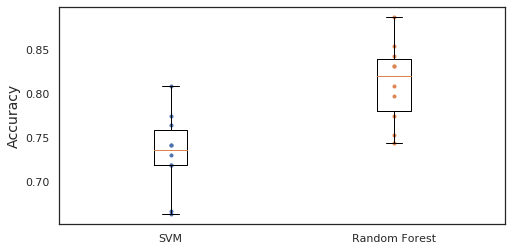

In [58]:
plt.figure(figsize = (8,4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels = ('SVM', 'Random Forest'))
plt.ylabel('Accuracy', fontsize = 14)